# Install Required Libraries

In [1]:
pip install tensorflow==2.15.0 matplotlib opencv-python seaborn vit-keras tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
  Attempting uninstall: keras
    Found existing install

In [2]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import shutil
import time
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from collections import Counter
from shutil import copy2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# Set Global Seed for Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Ensure TensorFlow uses Deterministic Operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
os.listdir("/kaggle/input/fish-eyes-freshness-split-dataset")

['val', 'test', 'train']

In [5]:
print(tf.__version__)

2.15.0


# Load & Explore Dataset

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


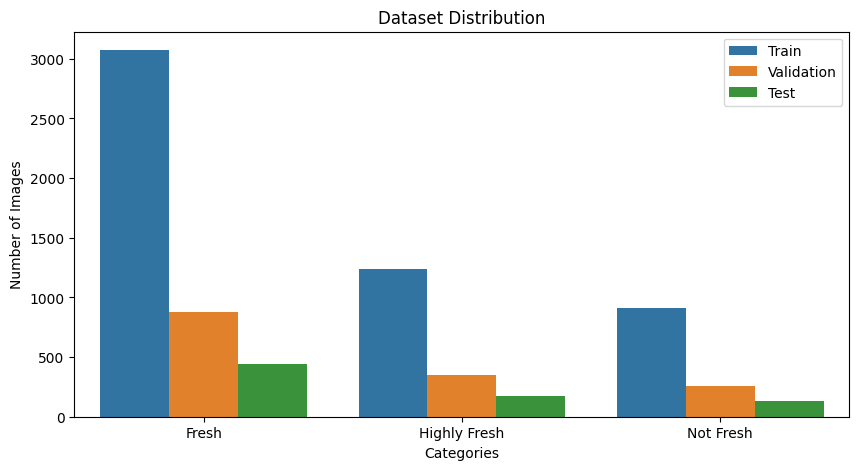

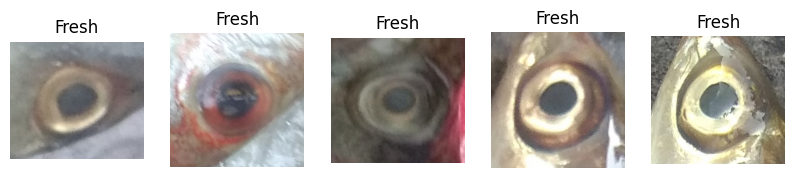

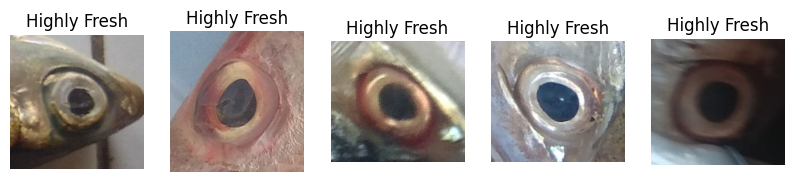

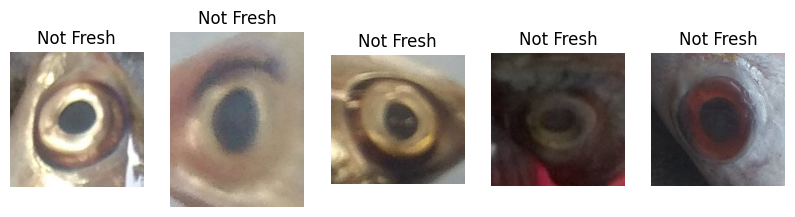

In [6]:
# Set dataset path
dataset_path = "/kaggle/input/fish-eyes-freshness-split-dataset"
sets = ['train', 'val', 'test']
categories = ['Fresh', 'Highly Fresh', 'Not Fresh']

# Count images in each class
data_distribution = {}
for set_name in sets:
    data_distribution[set_name] = {}
    for category in categories:
        folder_path = os.path.join(dataset_path, set_name, category)
        num_images = len(os.listdir(folder_path))
        data_distribution[set_name][category] = num_images

# Plot dataset distribution
plt.figure(figsize=(10, 5))
sns.barplot(
    x=categories * 3,
    y=[data_distribution['train'][c] for c in categories] + 
      [data_distribution['val'][c] for c in categories] + 
      [data_distribution['test'][c] for c in categories],
    hue=['Train']*3 + ['Validation']*3 + ['Test']*3
)
plt.title("Dataset Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Categories")
plt.show()

# Display sample images
def display_images(set_name, category, num_images=5):
    folder_path = os.path.join(dataset_path, set_name, category)
    images = os.listdir(folder_path)[:num_images]
    
    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"{category}")
        plt.axis("off")
    plt.show()

# Show sample images from each category
for category in categories:
    display_images("train", category)

# Data Augmentation & Balancing the Dataset

In [7]:
# Paths
dataset_path = "/kaggle/input/fish-eyes-freshness-split-dataset/train"
output_path = "/kaggle/working/balanced_dataset/train/"

# Define categories
categories = ["Fresh", "Highly Fresh", "Not Fresh"]

# Define target number of images per class (Set the max count of the largest category)
TARGET_SIZE = 3073  # Max count of the 'Fresh' class

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create output directories
for category in categories:
    os.makedirs(os.path.join(output_path, category), exist_ok=True)

# Function to balance dataset
def balance_dataset():
    for category in categories:
        input_dir = os.path.join(dataset_path, category)
        output_dir = os.path.join(output_path, category)

        # Get list of original images
        image_files = os.listdir(input_dir)
        num_images = len(image_files)

        # Copy existing images first
        for img in image_files:
            shutil.copy(os.path.join(input_dir, img), os.path.join(output_dir, img))

        print(f"Original {category}: {num_images} images")

        # Augment images if needed
        if num_images < TARGET_SIZE:
            extra_needed = TARGET_SIZE - num_images
            print(f"Generating {extra_needed} images for {category}...")

            # Augment until we reach target size
            while len(os.listdir(output_dir)) < TARGET_SIZE:
                img_file = random.choice(image_files)
                img = load_img(os.path.join(input_dir, img_file))
                img_array = img_to_array(img)
                img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for augmentation

                # Generate 1 augmented image per iteration
                for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_dir, save_format="jpeg"):
                    break  # Generate one image at a time

        print(f"Balanced {category}: {len(os.listdir(output_dir))} images\n")

# Run balancing function
balance_dataset()

Original Fresh: 3073 images
Balanced Fresh: 3073 images

Original Highly Fresh: 1234 images
Generating 1839 images for Highly Fresh...
Balanced Highly Fresh: 3073 images

Original Not Fresh: 914 images
Generating 2159 images for Not Fresh...
Balanced Not Fresh: 3073 images



In [8]:
output_path = "/kaggle/working/balanced_dataset/train/"
categories = ["Fresh", "Highly Fresh", "Not Fresh"]

for category in categories:
    num_images = len(os.listdir(os.path.join(output_path, category)))
    print(f"{category}: {num_images} images")

Fresh: 3073 images
Highly Fresh: 3073 images
Not Fresh: 3073 images


In [9]:
def count_images(folder):
    return sum(len(files) for _, _, files in os.walk(folder))

train_fresh = count_images("/kaggle/working/balanced_dataset/train/Fresh")
train_highly_fresh = count_images("/kaggle/working/balanced_dataset/train/Highly Fresh")
train_not_fresh = count_images("/kaggle/working/balanced_dataset/train/Not Fresh")

print(f"Fresh: {train_fresh}, Highly Fresh: {train_highly_fresh}, Not Fresh: {train_not_fresh}")

Fresh: 3073, Highly Fresh: 3073, Not Fresh: 3073


In [10]:
# shutil.make_archive('/kaggle/working/my_balanced_dataset', 'zip', '/kaggle/working/balanced_dataset')

In [11]:
# shutil.make_archive('/kaggle/working/FFE_Fish_Eyes_Split_Dataset', 'zip', '/kaggle/input/ffe-split-dataset/FFE_Split_Dataset')

# Early Stopping Implementation

In [12]:
# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# VGG16

--------

# Set Up Data Paths and Parameters

In [13]:
# Paths
train_dir = "/kaggle/working/balanced_dataset/train/"
val_dir = "/kaggle/input/fish-eyes-freshness-split-dataset/val"
test_dir = "/kaggle/input/fish-eyes-freshness-split-dataset/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001
EPOCHS = 50

SAVED_MODEL_FILENAME = 'best_vgg16_model.h5'
SAVED_MODEL_FILENAME_FINETUNE = 'best_vgg16_model_finetune.h5'

# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, classes=['Not Fresh', 'Fresh', 'Highly Fresh'], seed=SEED)
val_data = datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, classes=['Not Fresh', 'Fresh', 'Highly Fresh'], seed=SEED)
test_data = datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, classes=['Not Fresh', 'Fresh', 'Highly Fresh'], seed=SEED)

print("Class indices train:", train_data.class_indices)
print("Class indices val:", val_data.class_indices)
print("Class indices test:", test_data.class_indices)

Found 9219 images belonging to 3 classes.
Found 1492 images belonging to 3 classes.
Found 747 images belonging to 3 classes.
Class indices train: {'Not Fresh': 0, 'Fresh': 1, 'Highly Fresh': 2}
Class indices val: {'Not Fresh': 0, 'Fresh': 1, 'Highly Fresh': 2}
Class indices test: {'Not Fresh': 0, 'Fresh': 1, 'Highly Fresh': 2}


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
289/289 [==============================] - ETA: 0s - loss: 1.1849 - accuracy: 0.5075

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/289 [==============================] - 58s 188ms/step - loss: 1.1849 - accuracy: 0.5075 - val_loss: 0.9616 - val_accuracy: 0.5590
Epoch 2/50
289/289 [==============================] - 43s 147ms/step - loss: 0.8717 - accuracy: 0.5728 - val_loss: 1.0009 - val_accuracy: 0.5342
Epoch 3/50
289/289 [==============================] - 44s 151ms/step - loss: 0.8436 - accuracy: 0.5918 - val_loss: 0.9336 - val_accuracy: 0.5831
Epoch 4/50
289/289 [==============================] - 41s 141ms/step - loss: 0.8164 - accuracy: 0.6096 - val_loss: 0.9567 - val_accuracy: 0.5731
Epoch 5/50
289/289 [==============================] - 42s 145ms/step - loss: 0.7997 - accuracy: 0.6198 - val_loss: 0.9347 - val_accuracy: 0.5523
Epoch 6/50
289/289 [==============================] - 40s 137ms/step - loss: 0.7850 - accuracy: 0.6246 - val_loss: 0.9385 - val_accuracy: 0.5543
Epoch 7/50
289/289 [==============================] - 41s 142ms/step - loss: 0.7717 - accuracy: 0.6330 - val_loss: 0.9449 - val_accuracy: 0.5

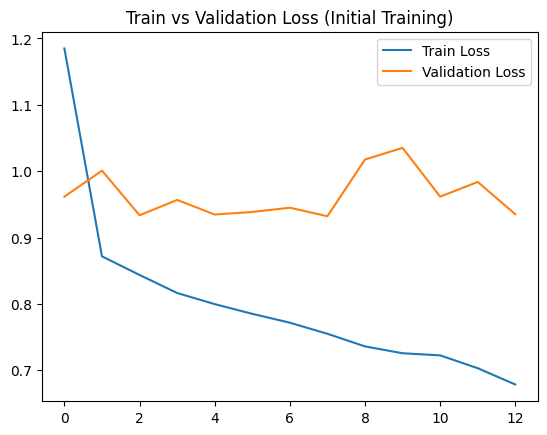

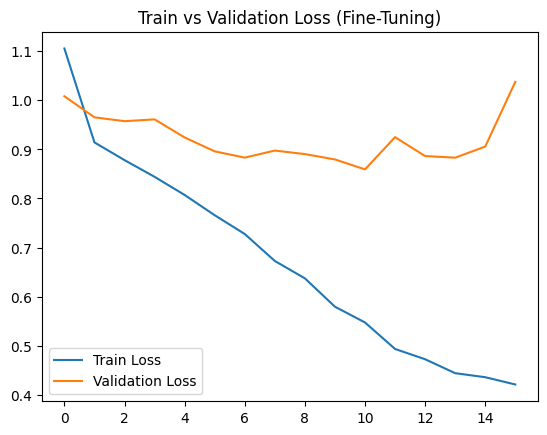

24/24 [==============================] - 8s 339ms/step - loss: 0.8511 - accuracy: 0.5649
VGG16 Test Loss: 0.8511
VGG16 Test Accuracy: 0.5649
24/24 [==============================] - 3s 139ms/step


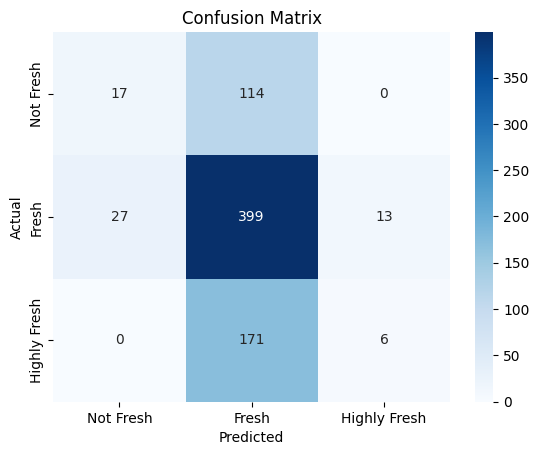

Classification Report:
               precision    recall  f1-score   support

   Not Fresh       0.39      0.13      0.19       131
       Fresh       0.58      0.91      0.71       439
Highly Fresh       0.32      0.03      0.06       177

    accuracy                           0.56       747
   macro avg       0.43      0.36      0.32       747
weighted avg       0.49      0.56      0.47       747



In [14]:
# Load Pretrained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers to prevent early overfitting
for layer in base_model.layers:
    layer.trainable = False

# Add classification head
x = Flatten()(base_model.output)
x = Dropout(DROPOUT_RATE)(x)  # Increased dropout to prevent overfitting
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT_RATE)(x)  # Additional dropout layer
output = Dense(3, activation="softmax")(x)  # 3 classes

# Build & Compile Model
model_vgg16 = Model(inputs=base_model.input, outputs=output)

# Compile with lower learning rate
model_vgg16.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

# Model checkpoint to save best model
mcp = ModelCheckpoint(filepath=SAVED_MODEL_FILENAME, save_best_only=True, monitor='val_loss', mode='min')
mcp_ft = ModelCheckpoint(filepath=SAVED_MODEL_FILENAME_FINETUNE, save_best_only=True, monitor='val_loss', mode='min')

# Train Model & Measure Time
start_time = time.time()
history_vgg16 = model_vgg16.fit(
    train_data, validation_data=val_data, epochs=EPOCHS,  # Increased max epochs
    batch_size=BATCH_SIZE, callbacks=[early_stop, mcp]  # Apply early stopping
)

end_time = time.time()
print(f"Initial Training Time: {end_time - start_time:.2f} seconds")

# After initial training, unfreeze the top layers of the VGG16 base model for fine-tuning
for layer in base_model.layers[-10:]:  # Unfreeze the last n layers (or experiment with other numbers)
    layer.trainable = True

# Recompile the model with a lower learning rate to fine-tune the last layers
model_vgg16.compile(optimizer=Adam(learning_rate=LEARNING_RATE*0.1),  # Lower learning rate for fine-tuning
                    loss="categorical_crossentropy", 
                    metrics=["accuracy"])

# Train Model & Measure Time (Fine-Tuning)
start_time = time.time()

# Continue training with the unfrozen layers
history_vgg16_finetune = model_vgg16.fit(
    train_data, validation_data=val_data, epochs=EPOCHS,  # Fine-tune for another epochs
    batch_size=BATCH_SIZE, callbacks=[early_stop, mcp_ft]
)
end_time = time.time()
print(f"Fine-Tuning Training Time: {end_time - start_time:.2f} seconds")

# Plot Train Loss & Validation Loss (Initial Training)
plt.plot(history_vgg16.history["loss"], label="Train Loss")
plt.plot(history_vgg16.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Train vs Validation Loss (Initial Training)")
plt.show()

# Plot Train Loss & Validation Loss (Fine-Tuning)
plt.plot(history_vgg16_finetune.history["loss"], label="Train Loss")
plt.plot(history_vgg16_finetune.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Train vs Validation Loss (Fine-Tuning)")
plt.show()

# Evaluate on Test Data
test_loss, test_acc = model_vgg16.evaluate(test_data)
print(f"VGG16 Test Loss: {test_loss:.4f}")
print(f"VGG16 Test Accuracy: {test_acc:.4f}")

# Confusion Matrix & Classification Report
y_true = test_data.classes
y_pred = np.argmax(model_vgg16.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_data.class_indices))

==============================================================================

# Vision Transformer (ViT)

# Set Up Data Paths and Parameters

In [15]:
# Paths
train_dir = "/kaggle/working/balanced_dataset/train/"
val_dir = "/kaggle/input/fish-eyes-freshness-split-dataset/val"
test_dir = "/kaggle/input/fish-eyes-freshness-split-dataset/test"

IMG_SIZE = 224
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001
EPOCHS = 50

SAVED_MODEL_FILENAME = 'best_vit_model.h5'
SAVED_MODEL_FILENAME_FINETUNE = 'best_vit_model_finetune.h5'

# Image preprocessing 
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, classes=['Not Fresh', 'Fresh', 'Highly Fresh'], seed=SEED)
val_data = datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, classes=['Not Fresh', 'Fresh', 'Highly Fresh'], seed=SEED)
test_data = datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, classes=['Not Fresh', 'Fresh', 'Highly Fresh'], seed=SEED)

print("Class indices train:", train_data.class_indices)
print("Class indices val:", val_data.class_indices)
print("Class indices test:", test_data.class_indices)

Found 9219 images belonging to 3 classes.
Found 1492 images belonging to 3 classes.
Found 747 images belonging to 3 classes.
Class indices train: {'Not Fresh': 0, 'Fresh': 1, 'Highly Fresh': 2}
Class indices val: {'Not Fresh': 0, 'Fresh': 1, 'Highly Fresh': 2}
Class indices test: {'Not Fresh': 0, 'Fresh': 1, 'Highly Fresh': 2}


# Vision Transformer (ViT) Training Code

347502902/347502902 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/50
289/289 [==============================] - ETA: 0s - loss: 0.9205 - accuracy: 0.5702

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/289 [==============================] - 124s 387ms/step - loss: 0.9205 - accuracy: 0.5702 - val_loss: 0.9276 - val_accuracy: 0.5489
Epoch 2/50
289/289 [==============================] - 110s 379ms/step - loss: 0.7666 - accuracy: 0.6304 - val_loss: 0.9145 - val_accuracy: 0.5362
Epoch 3/50
289/289 [==============================] - 109s 376ms/step - loss: 0.7335 - accuracy: 0.6414 - val_loss: 0.9077 - val_accuracy: 0.5664
Epoch 4/50
289/289 [==============================] - 108s 375ms/step - loss: 0.7090 - accuracy: 0.6565 - val_loss: 0.9181 - val_accuracy: 0.5188
Epoch 5/50
289/289 [==============================] - 109s 378ms/step - loss: 0.6872 - accuracy: 0.6670 - val_loss: 0.9028 - val_accuracy: 0.5536
Epoch 6/50
289/289 [==============================] - 110s 382ms/step - loss: 0.6797 - accuracy: 0.6689 - val_loss: 0.8922 - val_accuracy: 0.5402
Epoch 7/50
289/289 [==============================] - 108s 374ms/step - loss: 0.6597 - accuracy: 0.6800 - val_loss: 0.8990 - val_accura

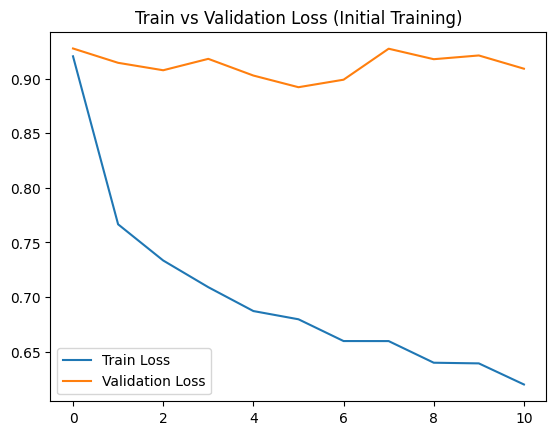

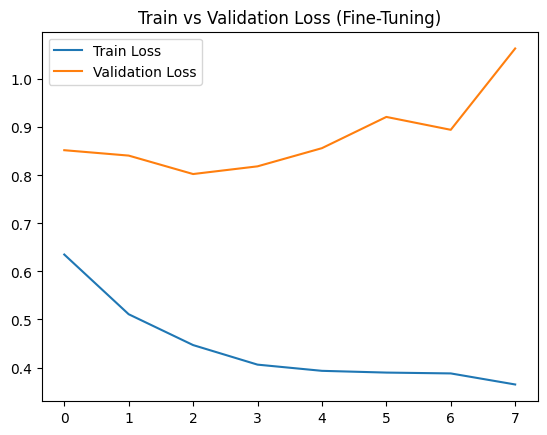

24/24 [==============================] - 8s 348ms/step - loss: 0.8139 - accuracy: 0.5261
ViT Test Loss: 0.8139
ViT Test Accuracy: 0.5261
24/24 [==============================] - 10s 318ms/step


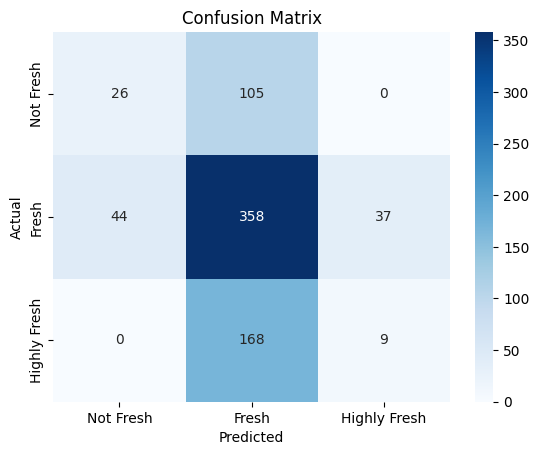

Classification Report:
               precision    recall  f1-score   support

   Not Fresh       0.37      0.20      0.26       131
       Fresh       0.57      0.82      0.67       439
Highly Fresh       0.20      0.05      0.08       177

    accuracy                           0.53       747
   macro avg       0.38      0.35      0.34       747
weighted avg       0.44      0.53      0.46       747



In [16]:
# Load Pretrained ViT Model
vit_model = vit.vit_b16(
    image_size=IMG_SIZE,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

# Freeze base layers (similar to VGG16)
for layer in vit_model.layers:
    layer.trainable = False

# Build the Classification Model (Add classification layers on top of the ViT model)
x = vit_model.output
x = Flatten()(x)
x = Dropout(DROPOUT_RATE)(x)  # Increased dropout to prevent overfitting
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT_RATE)(x)  # Additional dropout layer
output = Dense(3, activation="softmax")(x)  # 3 classes

model_vit = Model(inputs=vit_model.input, outputs=output)

# Compile the Model (Configure the model with an optimizer, loss function, and metrics)
model_vit.compile(optimizer=Adam(learning_rate=LEARNING_RATE),  # Initial learning rate
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

# Set Up Callback for model checkpointing
mcp = ModelCheckpoint(filepath=SAVED_MODEL_FILENAME, save_best_only=True, monitor='val_loss', mode='min')
mcp_ft = ModelCheckpoint(filepath=SAVED_MODEL_FILENAME_FINETUNE, save_best_only=True, monitor='val_loss', mode='min')

# Train the Model (Fit the model on the training data and validate it on the validation data)
start_time = time.time()
history_vit = model_vit.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,  # Increased max epochs
    callbacks=[early_stop, mcp]
)
end_time = time.time()
print(f"Initial Training Time: {end_time - start_time:.2f} seconds")

# After initial training, unfreeze the top layers of the ViT base model for fine-tuning
for layer in vit_model.layers[-10:]:  # Unfreeze the last n layers (experiment with different numbers)
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model_vit.compile(optimizer=Adam(learning_rate=LEARNING_RATE * 0.1),  # Lower learning rate for fine-tuning
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

# Train Model for Fine-Tuning (Continue training with the unfrozen layers)
start_time = time.time()
history_vit_finetune = model_vit.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,  # Fine-tune for another set of epochs
    callbacks=[early_stop, mcp_ft]
)
end_time = time.time()
print(f"Fine-Tuning Training Time: {end_time - start_time:.2f} seconds")

# Plot Train Loss & Validation Loss (Initial Training)
plt.plot(history_vit.history["loss"], label="Train Loss")
plt.plot(history_vit.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Train vs Validation Loss (Initial Training)")
plt.show()

# Plot Train Loss & Validation Loss (Fine-Tuning)
plt.plot(history_vit_finetune.history["loss"], label="Train Loss")
plt.plot(history_vit_finetune.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Train vs Validation Loss (Fine-Tuning)")
plt.show()

# Evaluate the Model (Test Data Performance)
test_loss, test_acc = model_vit.evaluate(test_data)
print(f"ViT Test Loss: {test_loss:.4f}")
print(f"ViT Test Accuracy: {test_acc:.4f}")

# Generate Confusion Matrix and Classification Report (Evaluate Predictions)
y_true = test_data.classes
y_pred = np.argmax(model_vit.predict(test_data), axis=1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Not Fresh', 'Fresh', 'Highly Fresh']))

==============================================================================

# Combination of VGG16 & ViT Features for Classification (Hybrid Model)

# Create a Custom Generator to provide two identical inputs (one for VGG16, one for ViT)

In [17]:
class DualInputGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, batch_size):
        self.generator = generator
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        # Get batch from the original generator
        batch_x, batch_y = self.generator[index]
        
        # Duplicate the images for VGG16 and ViT
        return [batch_x, batch_x], batch_y

# Set Up Data Paths and Parameters

In [18]:
# Paths
train_dir = "/kaggle/working/balanced_dataset/train/"
val_dir = "/kaggle/input/fish-eyes-freshness-split-dataset/val"
test_dir = "/kaggle/input/fish-eyes-freshness-split-dataset/test"

IMG_SIZE = 224  
BATCH_SIZE = 32  
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.0005
EPOCHS = 50

SAVED_MODEL_FILENAME = 'best_combined_vgg16_vit_model.h5'
SAVED_MODEL_FILENAME_FINETUNE = 'best_combined_vgg16_vit_model_finetune.h5'

# Combination of VGG16 & ViT Training Code

Found 9219 images belonging to 3 classes.
Found 1492 images belonging to 3 classes.
Found 747 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/50
289/289 [==============================] - ETA: 0s - loss: 1.1433 - accuracy: 0.3445

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/289 [==============================] - 355s 1s/step - loss: 1.1433 - accuracy: 0.3445 - val_loss: 1.0711 - val_accuracy: 0.4886
Epoch 2/50
289/289 [==============================] - 315s 1s/step - loss: 1.0884 - accuracy: 0.3846 - val_loss: 1.0385 - val_accuracy: 0.5188
Epoch 3/50
289/289 [==============================] - 311s 1s/step - loss: 1.0204 - accuracy: 0.4502 - val_loss: 1.0686 - val_accuracy: 0.4933
Epoch 4/50
289/289 [==============================] - 311s 1s/step - loss: 1.0043 - accuracy: 0.4649 - val_loss: 1.0410 - val_accuracy: 0.5389
Epoch 5/50
289/289 [==============================] - 317s 1s/step - loss: 0.9622 - accuracy: 0.5060 - val_loss: 1.0036 - val_accuracy: 0.5610
Epoch 6/50
289/289 [==============================] - 314s 1s/step - loss: 0.9365 - accuracy: 0.5416 - val_loss: 1.0145 - val_accuracy: 0.5429
Epoch 7/50
289/289 [==============================] - 313s 1s/step - loss: 0.9060 - accuracy: 0.5673 - val_loss: 1.0363 - val_accuracy: 0.5201
Epoch 8/50

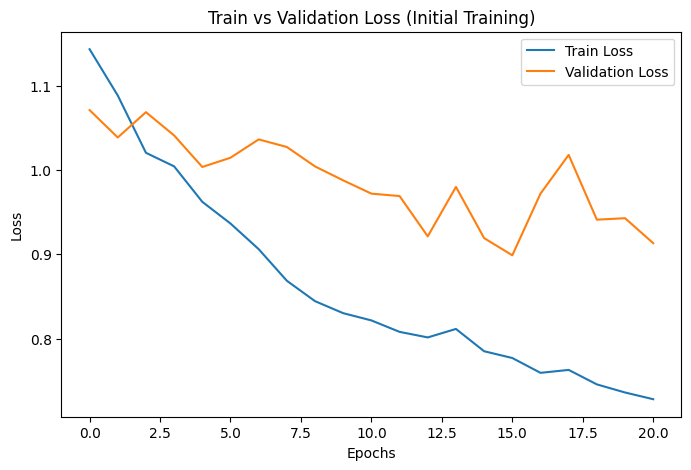

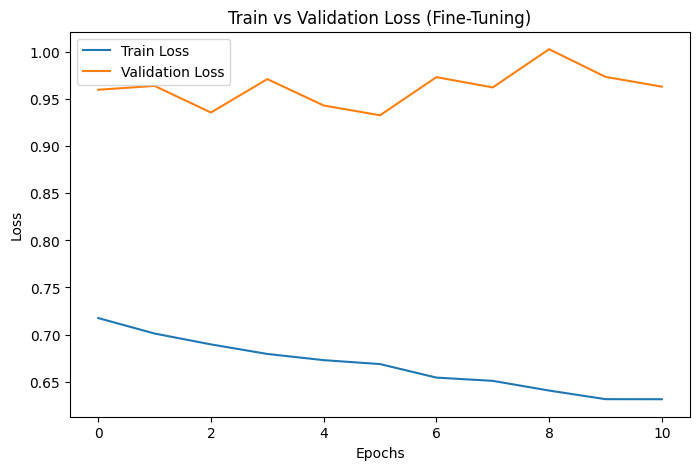

24/24 [==============================] - 10s 434ms/step - loss: 0.9425 - accuracy: 0.5435
Test Loss: 0.9425
Test Accuracy: 0.5435
24/24 [==============================] - 12s 403ms/step


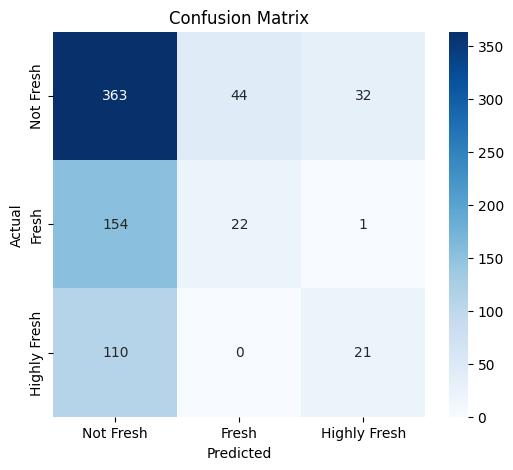

Classification Report:
               precision    recall  f1-score   support

   Not Fresh       0.58      0.83      0.68       439
       Fresh       0.33      0.12      0.18       177
Highly Fresh       0.39      0.16      0.23       131

    accuracy                           0.54       747
   macro avg       0.43      0.37      0.36       747
weighted avg       0.49      0.54      0.48       747



In [19]:
# Apply Image Preprocessing and Efficient Data Loading 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed=SEED)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed=SEED)

# Wrap with DualInputGenerator
train_dual_generator = DualInputGenerator(train_generator, BATCH_SIZE)
val_dual_generator = DualInputGenerator(val_generator, BATCH_SIZE)
test_dual_generator = DualInputGenerator(test_generator, BATCH_SIZE)

# Load Pretrained Models
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
vgg16_output = Flatten()(vgg16_base.output)
vgg16_output = Dropout(DROPOUT_RATE)(vgg16_output)  

vit_model = vit.vit_b16(image_size=IMG_SIZE, pretrained=True, include_top=False, pretrained_top=False)
vit_output = Flatten()(vit_model.output)
vit_output = Dropout(DROPOUT_RATE)(vit_output)  

# Combine Features
combined_features = Concatenate()([vgg16_output, vit_output])

# Fully Connected Layers
x = Dense(512, activation="relu")(combined_features)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(3, activation="softmax")(x)

# Define Model
model_combined = Model(inputs=[vgg16_base.input, vit_model.input], outputs=output)

# Compile Model
model_combined.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="categorical_crossentropy", metrics=["accuracy"])

# Set Up Callback for model checkpointing
mcp = ModelCheckpoint(filepath=SAVED_MODEL_FILENAME, save_best_only=True, monitor='val_loss', mode='min')
mcp_ft = ModelCheckpoint(filepath=SAVED_MODEL_FILENAME_FINETUNE, save_best_only=True, monitor='val_loss', mode='min')

# Train Model with Dual Input Generator
start_time = time.time()
history_combined = model_combined.fit(
    train_dual_generator,
    epochs=EPOCHS,
    validation_data=val_dual_generator,
    callbacks=[early_stop, mcp]
)
end_time = time.time()
print(f"Initial Training Time: {end_time - start_time:.2f} seconds")

# After initial training, unfreeze the top layers of VGG16 and ViT for fine-tuning
# Unfreeze last 10 layers of both models (you can adjust this based on your experiment)
for layer in vgg16_base.layers[-10:]:
    layer.trainable = True

for layer in vit_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model_combined.compile(optimizer=Adam(learning_rate=LEARNING_RATE*0.1),  # Lower learning rate for fine-tuning
                       loss="categorical_crossentropy", 
                       metrics=["accuracy"])

# Train Model & Measure Time (Fine-Tuning)
start_time = time.time()
history_combined_finetune = model_combined.fit(
    train_dual_generator,
    epochs=EPOCHS,
    validation_data=val_dual_generator,
    callbacks=[early_stop, mcp_ft]
)
end_time = time.time()
print(f"Fine-Tuning Training Time: {end_time - start_time:.2f} seconds")

# Plot Train vs Validation Loss (Initial Training)
plt.figure(figsize=(8, 5))
plt.plot(history_combined.history["loss"], label="Train Loss")
plt.plot(history_combined.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Train vs Validation Loss (Initial Training)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot Train vs Validation Loss (Fine-Tuning)
plt.figure(figsize=(8, 5))
plt.plot(history_combined_finetune.history["loss"], label="Train Loss")
plt.plot(history_combined_finetune.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Train vs Validation Loss (Fine-Tuning)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Evaluate on Test Data
test_loss, test_acc = model_combined.evaluate(test_dual_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix & Classification Report
y_true = test_generator.classes
y_pred = np.argmax(model_combined.predict(test_dual_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Fresh', 'Fresh', 'Highly Fresh'],
            yticklabels=['Not Fresh', 'Fresh', 'Highly Fresh'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Not Fresh', 'Fresh', 'Highly Fresh']))

# Load the VGG16 & ViT Combination Model and Evaluate Accuracy

In [20]:
# Efficient Data Loading
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed=SEED)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed=SEED)

# Wrap with DualInputGenerator
train_dual_generator = DualInputGenerator(train_generator, BATCH_SIZE)
val_dual_generator = DualInputGenerator(val_generator, BATCH_SIZE)
test_dual_generator = DualInputGenerator(test_generator, BATCH_SIZE)

Found 9219 images belonging to 3 classes.
Found 1492 images belonging to 3 classes.
Found 747 images belonging to 3 classes.


24/24 [==============================] - 12s 385ms/step - loss: 0.9425 - accuracy: 0.5435
Test Loss: 0.9425
Test Accuracy: 0.5435
24/24 [==============================] - 13s 411ms/step
Classification Report:
               precision    recall  f1-score   support

   Not Fresh       0.58      0.83      0.68       439
       Fresh       0.33      0.12      0.18       177
Highly Fresh       0.39      0.16      0.23       131

    accuracy                           0.54       747
   macro avg       0.43      0.37      0.36       747
weighted avg       0.49      0.54      0.48       747



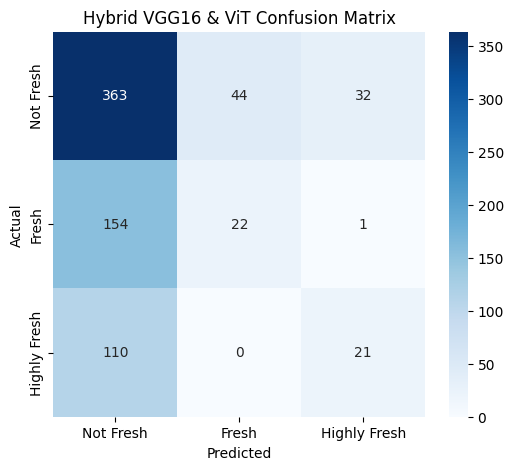

In [21]:
# Load the best model saved during training
best_model = load_model('/kaggle/working/best_combined_vgg16_vit_model_finetune.h5')

# Evaluate the model on the test dataset
test_loss, test_acc = best_model.evaluate(test_dual_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Get the true labels and predicted labels for the test data
y_true = test_generator.classes  # True labels
y_pred = np.argmax(best_model.predict(test_dual_generator), axis=1)  # Predicted labels

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Not Fresh', 'Fresh', 'Highly Fresh']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Fresh', 'Fresh', 'Highly Fresh'],
            yticklabels=['Not Fresh', 'Fresh', 'Highly Fresh'])
plt.title("Hybrid VGG16 & ViT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Fish Eyes Freshness Predictions

1/1 [==============================] - 3s 3s/step


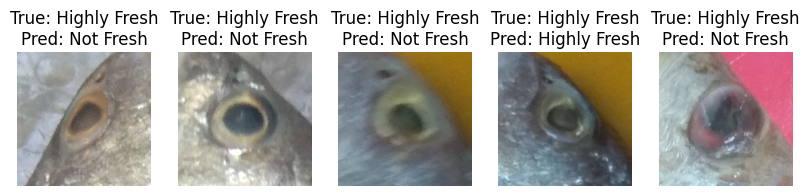

In [22]:
# Get a batch of data from the test generator
sample_batch = test_dual_generator.__getitem__(23) 

# Unpack the batch into images and labels
sample_images, sample_labels = sample_batch

# Make predictions for the batch
predictions = best_model.predict(sample_images)  # Assuming the model takes VGG16 and ViT inputs
predicted_classes = np.argmax(predictions, axis=1)

# Compare predictions with true labels
true_classes = np.argmax(sample_labels, axis=1)

# Plot the images with their true and predicted labels
plt.figure(figsize=(10, 10))

# Number of images to display (let's say we display 5 images)
num_images_to_display = 5

# Iterate through the first `num_images_to_display` images in the batch
for i in range(num_images_to_display):
    # Plot each image individually
    plt.subplot(1, num_images_to_display, i+1)  # Plot the images in a row
    image = sample_images[0][i]  # Access the i-th image from the first input (VGG16 images)
    plt.imshow(image)  # Display the image
    plt.axis('off')  # Turn off axis
    plt.title(f"True: {['Not Fresh', 'Fresh', 'Highly Fresh'][true_classes[i]]}\nPred: {['Not Fresh', 'Fresh', 'Highly Fresh'][predicted_classes[i]]}")

plt.show()


# Load VGG16 and ViT Model Training (Separately)

24/24 [==============================] - 4s 144ms/step - loss: 0.8511 - accuracy: 0.5649
VGG16 Model - Test Loss: 0.8511, Test Accuracy: 0.5649
24/24 [==============================] - 10s 328ms/step - loss: 0.8139 - accuracy: 0.5261
ViT Model - Test Loss: 0.8139, Test Accuracy: 0.5261
24/24 [==============================] - 10s 316ms/step
VGG16 Classification Report:
              precision    recall  f1-score   support

   Not Fresh       0.39      0.13      0.19       131
       Fresh       0.58      0.91      0.71       439
Highly Fresh       0.32      0.03      0.06       177

    accuracy                           0.56       747
   macro avg       0.43      0.36      0.32       747
weighted avg       0.49      0.56      0.47       747

ViT Classification Report:
              precision    recall  f1-score   support

   Not Fresh       0.37      0.20      0.26       131
       Fresh       0.57      0.82      0.67       439
Highly Fresh       0.20      0.05      0.08       177

  

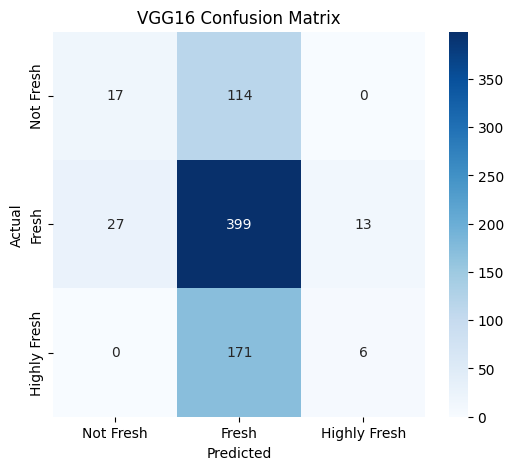

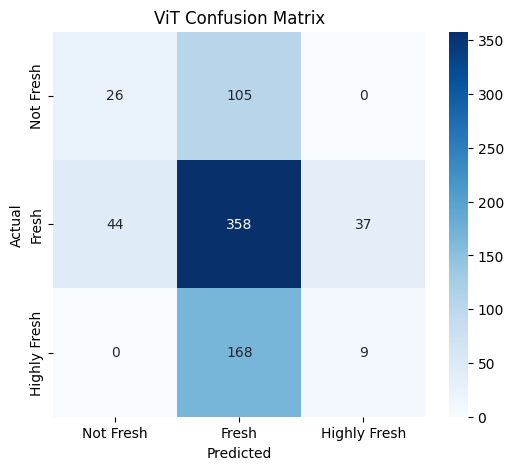

1/1 [==============================] - 1s 1s/step


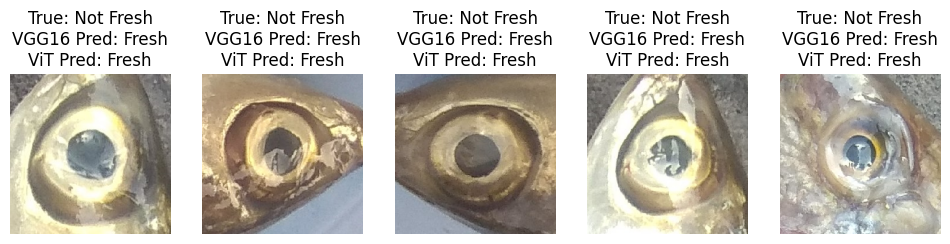

In [23]:
# Load the best VGG16 model
vgg16_model = load_model('/kaggle/working/best_vgg16_model_finetune.h5')

# Load the best ViT model
vit_model = load_model('/kaggle/working/best_vit_model_finetune.h5')

# Evaluate VGG16 model
vgg16_loss, vgg16_acc = vgg16_model.evaluate(test_data)
print(f"VGG16 Model - Test Loss: {vgg16_loss:.4f}, Test Accuracy: {vgg16_acc:.4f}")

# Evaluate ViT model
vit_loss, vit_acc = vit_model.evaluate(test_data)
print(f"ViT Model - Test Loss: {vit_loss:.4f}, Test Accuracy: {vit_acc:.4f}")

# Get true labels from the test generator
y_true = test_data.classes  # Get the true labels from the generator

# Make predictions using VGG16
vgg16_predictions = np.argmax(vgg16_model.predict(test_data), axis=1)

# Make predictions using ViT
vit_predictions = np.argmax(vit_model.predict(test_data), axis=1)

# Classification Report for VGG16
print("VGG16 Classification Report:")
print(classification_report(y_true, vgg16_predictions, target_names=['Not Fresh', 'Fresh', 'Highly Fresh']))

# Classification Report for ViT
print("ViT Classification Report:")
print(classification_report(y_true, vit_predictions, target_names=['Not Fresh', 'Fresh', 'Highly Fresh']))

# Confusion Matrix for VGG16
vgg16_cm = confusion_matrix(y_true, vgg16_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(vgg16_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Fresh', 'Fresh', 'Highly Fresh'],
            yticklabels=['Not Fresh', 'Fresh', 'Highly Fresh'])
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion Matrix for ViT
vit_cm = confusion_matrix(y_true, vit_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(vit_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Fresh', 'Fresh', 'Highly Fresh'],
            yticklabels=['Not Fresh', 'Fresh', 'Highly Fresh'])
plt.title("ViT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Get a sample batch of test images and their labels for visualization
sample_batch = test_data.next()  # Get the first batch

# Unpack the batch into images and labels
sample_images, sample_labels = sample_batch

# Make predictions for the batch using both models
vgg16_sample_predictions = np.argmax(vgg16_model.predict(sample_images), axis=1)
vit_sample_predictions = np.argmax(vit_model.predict(sample_images), axis=1)

# Plot a few images with their predictions
num_images_to_display = 5

plt.figure(figsize=(12, 12))

for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i+1)  # Plot the images in a row
    plt.imshow(sample_images[i])  # Display the image
    plt.axis('off')  # Turn off axis

    # Display the predicted class for VGG16 and ViT
    true_class = np.argmax(sample_labels[i], axis=0)
    vgg16_pred_class = vgg16_sample_predictions[i]
    vit_pred_class = vit_sample_predictions[i]

    plt.title(f"True: {['Not Fresh', 'Fresh', 'Highly Fresh'][true_class]}\n"
              f"VGG16 Pred: {['Not Fresh', 'Fresh', 'Highly Fresh'][vgg16_pred_class]}\n"
              f"ViT Pred: {['Not Fresh', 'Fresh', 'Highly Fresh'][vit_pred_class]}")

plt.show()